# KNN for Hand Pose Classification

K-nearest neighbors algorithm to classify multiple hand poses
* Dataset of poses available as multiple .csv files
* Each file contains poses for a different class 
* Each file name is use as the label for that class

In [1]:
!pip install numpy==1.19.3
!pip install mediapipe

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas
import os
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/Colab Notebooks/Deep Learning/KNN_Pose_Classification/handpose_data/'

Mounted at /content/drive


## Load Data

In [4]:
def load_pose_samples(pose_samples_folder, file_extension='csv'):
    """ Loads pose samples from a given folder."""

    # Each file in the folder represents one pose class.
    file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

    pose_samples = []
    class_samples = []
    for file_name in file_names:
        # Use file name as pose class name.
        class_name = file_name[:-(len(file_extension) + 1)]

        # Parse CSV.
        with open(os.path.join(pose_samples_folder, file_name)) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                landmarks = np.array(row[:], np.float32).reshape(21, 3)
                landmarks = landmarks[:, :2].reshape((42,))                     # use only 2d data
                pose_samples.append(landmarks)
                class_samples.append(class_name)
    return pose_samples, class_samples

In [5]:
x, y = load_pose_samples(data_dir)                                              # x: list with all instances as ndarray (42,) y: list with labels

## Draw Hand Landmarks

In [6]:
import math
from typing import List, Tuple, Union
import cv2
import mediapipe as mp


def _normalized_to_pixel_coordinates(normalized_x: float, normalized_y: float, image_width: int, image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and is_valid_normalized_value(normalized_y)):
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def draw_landmarks(image: np.ndarray, landmarks: np.ndarray, connections: List[Tuple[int, int]] = None):
  """Draws the landmarks and the connections on the image.
  Args:
    image: A three channel RGB image represented as numpy ndarray.
    landmarks: A normalized landmark numpy array 
    connections: A list of landmark index tuples that specifies how landmarks to be connected in the drawing.
  Raises:
    ValueError: If one of the followings:
      a) If the input image is not three channel RGB.
      b) If any connetions contain invalid landmark index.
  """
  if image.shape[2] != 3:
    raise ValueError('Input image must contain three channel rgb data.')
  image_rows, image_cols, _ = image.shape
  idx_to_coordinates = {}
  for idx in range(21):
    landmark_px = _normalized_to_pixel_coordinates(landmarks[2*idx], landmarks[2*idx+1], image_cols, image_rows)
    if landmark_px:
      idx_to_coordinates[idx] = landmark_px
  if connections:
    num_landmarks = 21
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
        cv2.line(image, idx_to_coordinates[start_idx], idx_to_coordinates[end_idx], (0, 255, 0), 2)
  
  # Draws landmark points after finishing the connection lines, which is aesthetically better.
  for landmark_px in idx_to_coordinates.values():
    cv2.circle(image, landmark_px, 2, (255, 0, 0), 2)

In [7]:
hand_connections = mp.solutions.hands.HAND_CONNECTIONS

def plot_random_pose(features, labels, indexes):
  plt.figure(figsize=(15, 15))
  for i in range(25):
    img = np.zeros((200, 200, 3), dtype = "uint8")
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    hand_landmarks = features[indexes[i]]
    draw_landmarks(img, hand_landmarks, hand_connections)
    plt.imshow(img)
    plt.xlabel(labels[indexes[i]])
plt.show()

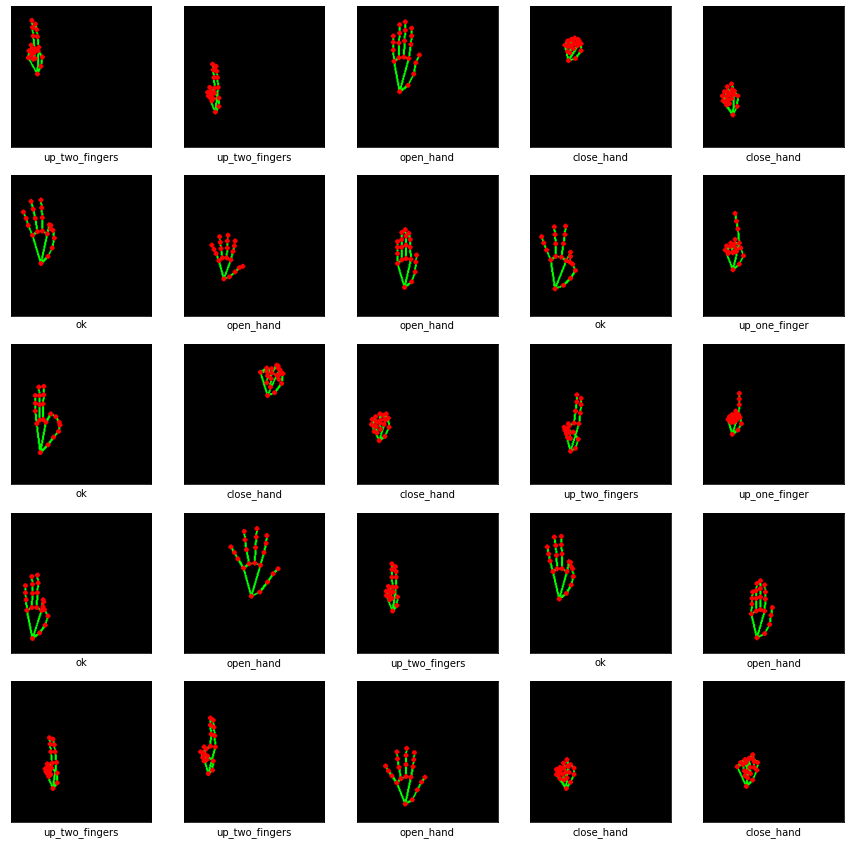

In [8]:
plot_random_pose(x,y, np.random.randint(len(y), size=25))

## Data Preparation

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)

## Hand Pose Embedding

In [10]:
class HandPoseEmbedder(object):
    """Converts 2D pose landmarks into 2D embedding."""

    def __init__(self):
        self._palm_size_multiplier = 2.5
        # Names of the landmarks as they appear in the prediction.
        self._landmark_names = [
            'WRIST',
            'THUMB_CMC','THUMB_MCP','THUMB_IP','THUMB_TIP',
            'INDEX_FINGER_MCP','INDEX_FINGER_PIP','INDEX_FINGER_DIP','INDEX_FINGER_TIP',
            'MIDDLE_FINGER_MCP','MIDDLE_FINGER_PIP','MIDDLE_FINGER_DIP','MIDDLE_FINGER_TIP',
            'RING_FINGER_MCP','RING_FINGER_PIP','RING_FINGER_DIP','RING_FINGER_TIP',
            'PINKY_MCP','PINKY_PIP','PINKY_DIP','PINKY_TIP',
        ]

    def __call__(self, landmarks):
        """Converts pose landmarks to embedding

        Args:
          landmarks - NumPy array with 2D landmarks of shape (N, 2).

        Result:
          Numpy array with pose embedding of shape (M, 2) where M is the number of
          pairwise distances defined in `_get_pose_distance_embedding`.
        """
        
        landmarks = landmarks.reshape(21,2)                                     # Get pose landmarks as 2D points
        landmarks = self._normalize_pose_landmarks(landmarks)
        embedding = self._get_pose_distance_embedding(landmarks)                # Feature vector representation as array size (k,2) 
        return embedding                                                        # where k is the dimension of the embedding

    def _normalize_pose_landmarks(self, landmarks):
        """Normalizes landmarks translation and scale."""
        landmarks = np.copy(landmarks)

        # Normalize translation.
        pose_center = self._get_pose_center(landmarks)
        landmarks -= pose_center

        # Normalize scale.
        pose_size = self._get_pose_size(landmarks, self._palm_size_multiplier)
        landmarks /= pose_size

        return landmarks

    def _get_pose_center(self, landmarks):
        """Calculates pose center as point between wrist and middle_finger_mcp"""
        if self._get_distance_norm_by_names(landmarks, 'WRIST', 'MIDDLE_FINGER_TIP') > self._get_distance_norm_by_names(landmarks, 'WRIST', 'MIDDLE_FINGER_MCP'):
            px_1 = landmarks[self._landmark_names.index('WRIST')]
            px_2 = landmarks[self._landmark_names.index('MIDDLE_FINGER_TIP')]
        else:
            px_1 = landmarks[self._landmark_names.index('WRIST')]
            px_2 = landmarks[self._landmark_names.index('MIDDLE_FINGER_MCP')]
        center = (px_1 + px_2) * 0.5
        return center

    def _get_pose_size(self, landmarks, palm_size_multiplier):
        """Calculates pose size.

        It is the maximum of two values:
          * Palm size multiplied by `palm_size_multiplier`
          * Maximum distance from pose center to any pose landmark
        """

        # Palm size as the minimum body size.
        wrist = landmarks[self._landmark_names.index('WRIST')]
        middle_mcp = landmarks[self._landmark_names.index('MIDDLE_FINGER_MCP')]
        palm_size = np.linalg.norm(wrist - middle_mcp)

        # Max dist to pose center.
        pose_center = self._get_pose_center(landmarks)
        max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

        return max(palm_size * palm_size_multiplier, max_dist)
    
    def _get_pose_distance_embedding(self, landmarks):
        """Converts pose landmarks into 2D embedding.

        We use several pairwise 2D distances to form pose embedding. All distances
        include X and Y components with sign. We use different types of pairs to cover
        different pose classes. Feel free to remove some or add new.

        Args:
          landmarks - NumPy array with 2D landmarks of shape (21, 2).

        Result:
          Numpy array with pose embedding of shape (k, 2) where k is the number of
          pairwise distances.
        """
        embedding = np.array([
            # One joint.
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'THUMB_MCP'),
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'INDEX_FINGER_MCP'),
            self._get_distance_by_names(landmarks, 'MIDDLE_FINGER_TIP', 'MIDDLE_FINGER_MCP'),
            self._get_distance_by_names(landmarks, 'RING_FINGER_TIP', 'RING_FINGER_MCP'),
            self._get_distance_by_names(landmarks, 'PINKY_TIP', 'PINKY_MCP'),

            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'THUMB_IP'),
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'INDEX_FINGER_PIP'),
            self._get_distance_by_names(landmarks, 'MIDDLE_FINGER_TIP', 'MIDDLE_FINGER_PIP'),
            self._get_distance_by_names(landmarks, 'RING_FINGER_TIP', 'RING_FINGER_PIP'),
            self._get_distance_by_names(landmarks, 'PINKY_TIP', 'PINKY_PIP'),

            # Two joints.
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'INDEX_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'MIDDLE_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'RING_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'PINKY_TIP'),
            
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'MIDDLE_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'RING_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'PINKY_TIP'),
            
            self._get_distance_by_names(landmarks, 'MIDDLE_FINGER_TIP', 'RING_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'MIDDLE_FINGER_TIP', 'PINKY_TIP'),

            self._get_distance_by_names(landmarks, 'RING_FINGER_TIP', 'PINKY_TIP'),

            # Four joints.
            self._get_distance_by_names(landmarks, 'WRIST', 'INDEX_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'WRIST', 'MIDDLE_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'WRIST', 'RING_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'WRIST', 'PINKY_TIP'),

            # Five joints.
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'MIDDLE_FINGER_MCP'),

        ])

        return embedding

    def _get_distance_by_names(self, landmarks, name_from, name_to):
        lmk_from = landmarks[self._landmark_names.index(name_from)]
        lmk_to = landmarks[self._landmark_names.index(name_to)]
        return self._get_distance(lmk_from, lmk_to)

    def _get_distance(self, lmk_from, lmk_to):
        return lmk_to - lmk_from

    def _get_distance_norm_by_names(self, landmarks, name_from, name_to):
        lmk_from = landmarks[self._landmark_names.index(name_from)]
        lmk_to = landmarks[self._landmark_names.index(name_to)]
        return self._get_distance_norm(lmk_from, lmk_to)

    def _get_distance_norm(self, lmk_from, lmk_to):
        return np.linalg.norm(lmk_to - lmk_from)    

## Custom KNN Classifier

In [11]:
class PoseSample(object):
    def __init__(self, landmarks, class_name, embedding):
        self.landmarks = landmarks
        self.class_name = class_name
        self.embedding = embedding

class PoseClassifier(object):
    """Classifies pose landmarks."""

    def __init__(self, pose_instances, pose_labels, pose_embedder):
        self.pose_embedder = pose_embedder
        self.n_landmarks = 21
        self.n_dimensions = 2
        self.top_n_by_max_distance = 30
        self.top_n_by_mean_distance = 10

        self.pose_samples = self._load_pose_samples_from_instances(pose_instances, pose_labels, pose_embedder)

    def _load_pose_samples_from_instances(self, pose_instances, pose_labels, pose_embedder):
        """ Loads pose instances as PoseSample objects"""

        pose_samples = []
        for landmarks, label in zip(pose_instances, pose_labels):
            pose_samples.append(PoseSample(landmarks, label, embedding=pose_embedder(landmarks)))

        return pose_samples

    def __call__(self, pose_landmarks):
        """Classifies given pose.

        Classification is done in two stages:
          * First we pick top-N samples by MAX distance. It allows to remove samples
            that are almost the same as given pose, but has few joints bent in the
            other direction.
          * Then we pick top-N samples by MEAN distance. After outliers are removed
            on a previous step, we can pick samples that are closes on average.

        Args:
          pose_landmarks: NumPy array with 2D landmarks of shape (42,).

        Returns:
          Dictionary with count of nearest pose samples from the database. Sample:
            {
              'open_hand': 8,
              'two_fingers': 2,
            }
        """

        # Get given pose embedding.
        pose_embedding = self.pose_embedder(pose_landmarks)
        #flipped_pose_embedding = self.pose_embedder(pose_landmarks * np.array([-1, 1, 1]))

        # Filter by max distance.
        #
        # That helps to remove outliers - poses that are almost the same as the
        # given one, but has one joint bent into another direction and actually
        # represnt a different pose class.
        max_dist_heap = []
        for sample_idx, sample in enumerate(self.pose_samples):
            max_dist = np.max(np.abs(sample.embedding - pose_embedding))
            max_dist_heap.append([max_dist, sample_idx])

        max_dist_heap = sorted(max_dist_heap, key=lambda x: x[0])
        max_dist_heap = max_dist_heap[:self.top_n_by_max_distance]

        # Filter by mean distance.
        #
        # After removing outliers we can find the nearest pose by mean distance.
        mean_dist_heap = []
        for _, sample_idx in max_dist_heap:
            sample = self.pose_samples[sample_idx]
            mean_dist = np.mean(np.abs(sample.embedding - pose_embedding))
            mean_dist_heap.append([mean_dist, sample_idx])

        mean_dist_heap = sorted(mean_dist_heap, key=lambda x: x[0])
        mean_dist_heap = mean_dist_heap[:self.top_n_by_mean_distance]

        # Collect results into map: (class_name -> n_samples)
        class_names = [self.pose_samples[sample_idx].class_name for _, sample_idx in mean_dist_heap]
        result = {class_name: class_names.count(class_name) for class_name in set(class_names)}

        return result

## Classification

In [12]:
# Initialize embedder.
Pose_embedder = HandPoseEmbedder()

# Initialize classifier.
knn_pose_classifier = PoseClassifier(X_train, y_train, Pose_embedder)

In [26]:
# Classify new pose
y_predict = []
for x in X_test:
    out_dict = knn_pose_classifier(x)
    y_predict.append(max(out_dict, key=out_dict.get))

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predict)

array([[501,   0,   0,   0,   0,   0],
       [  1, 104,   0,   0,   0,   0],
       [  0,   0, 153,   0,   0,   0],
       [  1,   0,   0, 393,   0,   0],
       [  1,   0,   0,   0,  96,   0],
       [  1,   0,   0,   0,   0, 395]])